In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


CSV and Excel file is at github /data folder

In [19]:
pip install rapidfuzz

In [20]:
# Required Libraries
import pandas as pd
import numpy as np
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, silhouette_score,  davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from rapidfuzz import process, fuzz
from collections import Counter
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sentence_transformers import SentenceTransformer
from ast import literal_eval
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**EDA with merged Job and Company Data**

In [21]:
data_path = '/content/drive/MyDrive/job_company.csv'

data = pd.read_csv(data_path, on_bad_lines='skip')

In [22]:
data.columns

Index(['job_id', 'title', 'description', 'company_id', 'location_id',
       'job_type_id', 'category_id', 'posted_date', 'closing_date',
       'salary_min', 'salary_max', 'is_featured', 'company_name',
       'company_website', 'company_description', 'company_logo', 'skills',
       'industries', 'job_type_name'],
      dtype='object')

In [23]:
columns_to_drop = ['job_id', 'company_id', 'location_id', 'job_type_id', 'category_id', 'is_featured', 'posted_date','closing_date', 'company_logo', 'company_website']
data = data.drop(columns= columns_to_drop, errors='ignore')
data= data.iloc[60:]

**Missing Value**

In [24]:
print("\nMissing Values in Data:")
print(data.isnull().sum())


Missing Values in Data:
title                    0
description              0
salary_min             501
salary_max             501
company_name             0
company_description    259
skills                   0
industries               0
job_type_name            0
dtype: int64


In [25]:
print(data.info())
print(data.describe())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653 entries, 60 to 712
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                653 non-null    object 
 1   description          653 non-null    object 
 2   salary_min           152 non-null    float64
 3   salary_max           152 non-null    float64
 4   company_name         653 non-null    object 
 5   company_description  394 non-null    object 
 6   skills               653 non-null    object 
 7   industries           653 non-null    object 
 8   job_type_name        653 non-null    object 
dtypes: float64(2), object(7)
memory usage: 46.0+ KB
None
          salary_min     salary_max
count     152.000000     152.000000
mean   124894.736842  166671.052632
std     46507.160724   59195.016829
min     39000.000000   55000.000000
25%     91500.000000  130000.000000
50%    120000.000000  162500.000000
75%    150000.000000  200000.000000

In [26]:
categories_list = data['industries'].apply(lambda x: x.split(','))
all_categories = [category.strip() for categories in categories_list for category in categories]
category_counts = Counter(all_categories)
top_10_categories = category_counts.most_common(10)

print("Top 10 Most Frequent Categories:")
for category, count in top_10_categories:
    print(f"{category}: {count}")

Top 10 Most Frequent Categories:
Software: 295
Information Technology: 135
Artificial Intelligence: 98
Cloud: 73
Healthtech: 73
Fintech: 64
Analytics: 60
Machine Learning: 47
Financial Services: 45
Biotech: 44


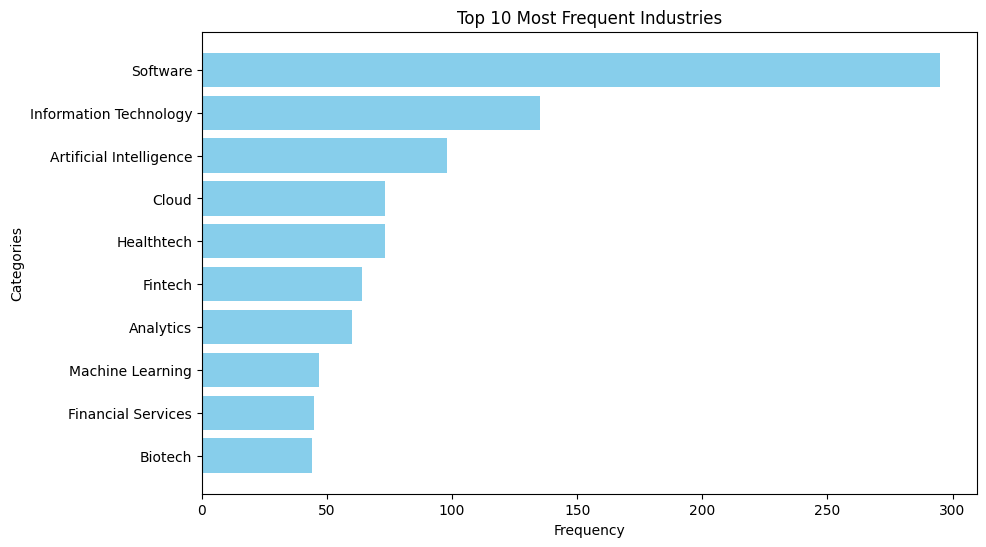

In [27]:
categories, counts = zip(*top_10_categories)

plt.figure(figsize=(10, 6))
plt.barh(categories, counts, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Categories')
plt.title('Top 10 Most Frequent Industries')
plt.gca().invert_yaxis()
plt.show()

## EDA with JOB Data Only

In [28]:
data_path = '/content/drive/MyDrive/job_after.xlsx'

try:
    data = pd.read_excel(data_path)
    print("Data loaded successfully!")
    print(data.head())
except Exception as e:
    print(f"Error loading Excel file: {e}")

Data loaded successfully!
                                         job_summary  \
0  The Lifecycle Marketing Specialist will drive ...   
1  The Group Product Manager at Crunchtime will l...   
2  The Sr. Video Editor at CommentSold will devel...   
3  The Implementation Manager at NationBuilder ov...   
4  The Head of Global API Sales will lead Vonage'...   

                   company_url                                  job_title  \
0     https://getcandidly.com/  Lifecycle Marketing Specialist (Contract)   
1      https://crunchtime.com/                      Group Product Manager   
2  http://www.commentsold.com/                           Sr. Video Editor   
3    http://nationbuilder.com/                     Implementation Manager   
4      https://www.vonage.com/                   Head of Global API Sales   

   company_title                                             skills work_type  \
0       Candidly  ['A/B Testing', 'Data Analysis', 'Email Market...    Remote   
1     Crunch

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2291 entries, 0 to 2290
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   job_summary     2290 non-null   object
 1   company_url     2291 non-null   object
 2   job_title       2291 non-null   object
 3   company_title   2291 non-null   object
 4   skills          2291 non-null   object
 5   work_type       2291 non-null   object
 6   minimum_salary  2291 non-null   object
 7   max_salary      2291 non-null   object
 8   avg_salary      2291 non-null   object
 9   employee_level  2291 non-null   object
dtypes: object(10)
memory usage: 179.1+ KB


**Salary Distribution**

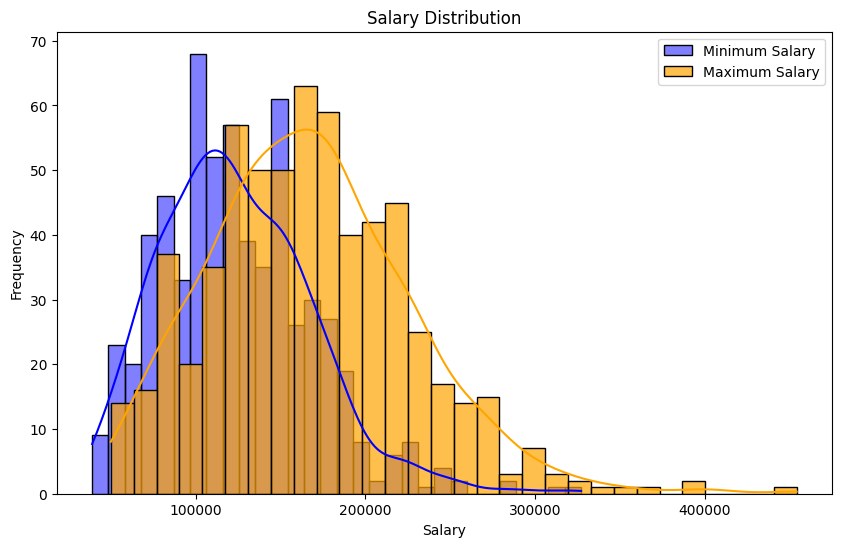

count       620.000000
mean      43780.645161
std       31570.373418
min           0.000000
25%       20000.000000
50%       35000.000000
75%       55000.000000
max      197000.000000
Name: salary_diff, dtype: float64


In [30]:
data['minimum_salary'] = pd.to_numeric(data['minimum_salary'], errors='coerce')
data['max_salary'] = pd.to_numeric(data['max_salary'], errors='coerce')

plt.figure(figsize=(10, 6))
sns.histplot(data['minimum_salary'], kde=True, bins=30, color='blue', label='Minimum Salary')
sns.histplot(data['max_salary'], kde=True, bins=30, color='orange', label='Maximum Salary', alpha=0.7)
plt.legend()
plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

data['salary_diff'] = data['max_salary'] - data['minimum_salary']
print(data['salary_diff'].describe())

**Job Type Distribution**

work_type
Remote    1900
Onsite     332
Hybrid      59
Name: count, dtype: int64


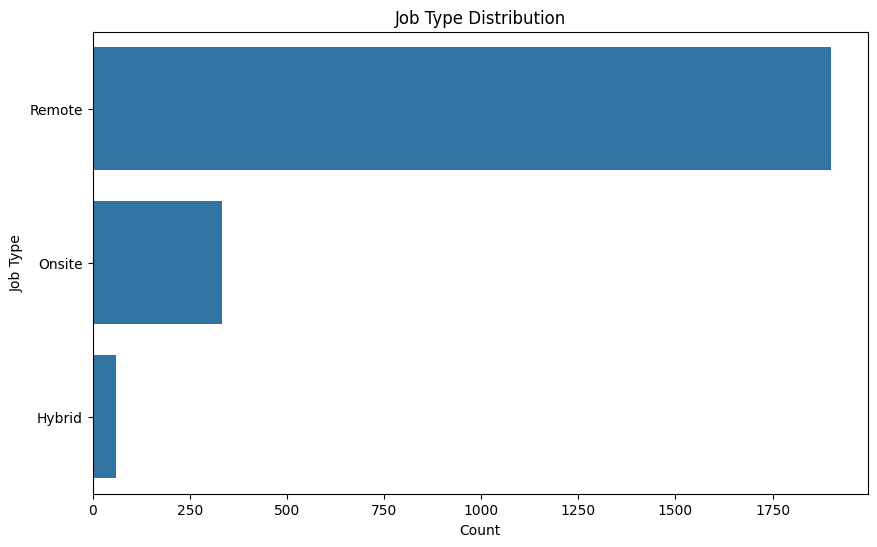

In [31]:
print(data['work_type'].value_counts())


plt.figure(figsize=(10, 6))
sns.countplot(y='work_type', data=data, order=data['work_type'].value_counts().index)
plt.title('Job Type Distribution')
plt.xlabel('Count')
plt.ylabel('Job Type')
plt.show()

**Top 10 Skills**

[('Python', 86), ('SQL', 44), ('Typescript', 38), ('JavaScript', 38), ('React', 35), ('Go', 33), ('Java', 29), ('AI', 23), ('C++', 23), ('Node.js', 21)]


<ipython-input-32-8d3a08ff126f>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(skills), palette="viridis", orient='h')


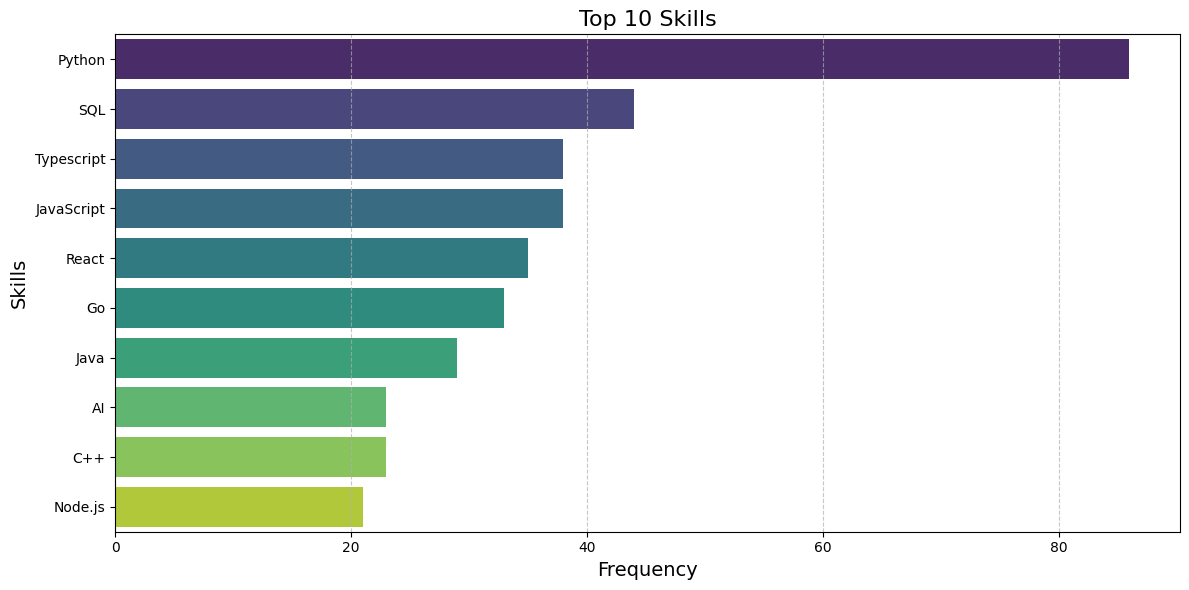

In [32]:
high_salary_threshold = data['minimum_salary'].quantile(0.75)
high_salary_data = data[data['max_salary'] >= high_salary_threshold]

def clean_skills(skills):
    if isinstance(skills, str):
        skills = skills.replace('[', '').replace(']', '').replace("'", '').strip()
        return [skill.strip() for skill in skills.split(',') if skill.strip()]
    return []

skills_list = high_salary_data['skills'].apply(clean_skills)
all_skills = [skill for skills in skills_list for skill in skills]

skill_counts = Counter(all_skills)
top_10_skills = skill_counts.most_common(10)
print(top_10_skills)

skills, counts = zip(*top_10_skills)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(skills), palette="viridis", orient='h')
plt.title('Top 10 Skills', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Skills', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Which employee level is most needed?

employee_level
Senior level     1028
Mid level         452
unknown           286
Junior            244
Entry level       191
Expert/Leader      90
Name: count, dtype: int64


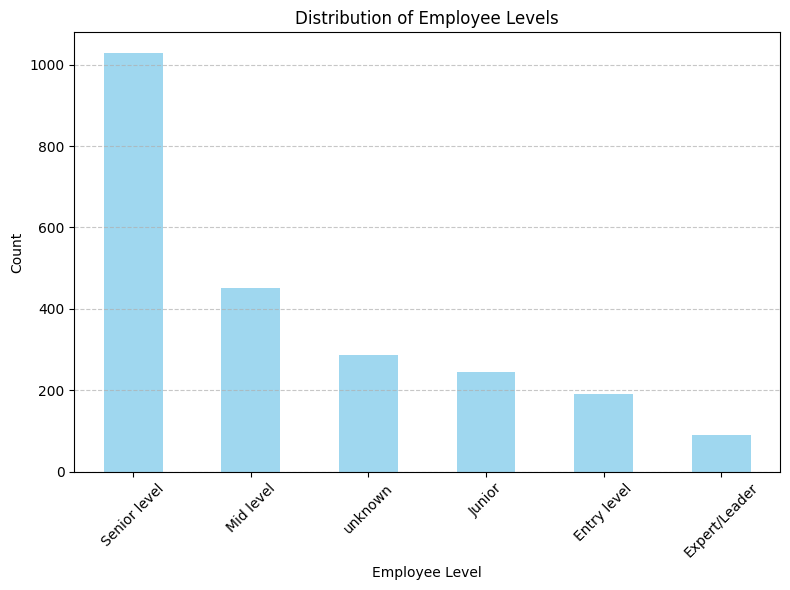

In [33]:
employee_level_counts = data['employee_level'].value_counts()

print(employee_level_counts)
plt.figure(figsize=(8, 6))
employee_level_counts.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title("Distribution of Employee Levels")
plt.xlabel("Employee Level")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Word Cloud in Job Summary**

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


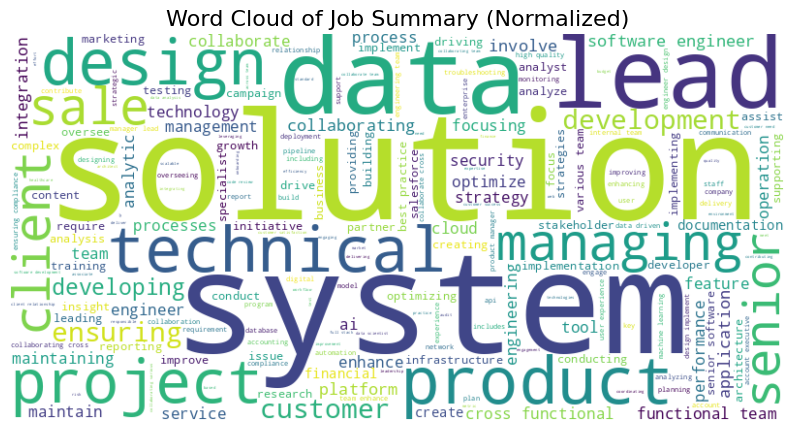

In [34]:
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def normalize_text(text):
    text = text.lower()

    words = text.split()
    normalized_words = [
        lemmatizer.lemmatize(word) for word in words if word not in custom_stopwords
    ]

    return " ".join(normalized_words)

custom_stopwords = set(STOPWORDS).union({
    "job", "position", "summary", "role", "responsibilities", "skills", "requirements",
    "applicant", "candidate", "ability", "experience", "working", "work", "team",
    "develop", "provide", "support", "include", "required", "preferred", "must",
    "good", "excellent", "strong", "help", "perform", "knowledge", "degree", "field",
    "tasks", "environment", "level", "manage", "ensure", "will", "can", "within",
    "may", "should", "shall", "one", "two", "three", "using", "like", "also",
    "etc", "new", "need", "must", "high", "low", "strong", "basic", "advanced",
    "learn", "well", "make", "using", "able"
})

if 'job_summary' in data.columns:
    text = ' '.join(data['job_summary'].dropna().astype(str))

    normalized_text = normalize_text(text)
else:
    print("The column 'job_summary' does not exist in the dataset.")
    normalized_text = ""

if normalized_text:
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='viridis',
        stopwords=None
    ).generate(normalized_text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud of Job Summary (Normalized)", fontsize=16)
    plt.show()
else:
    print("No text available for Word Cloud generation.")

Correlation between the features

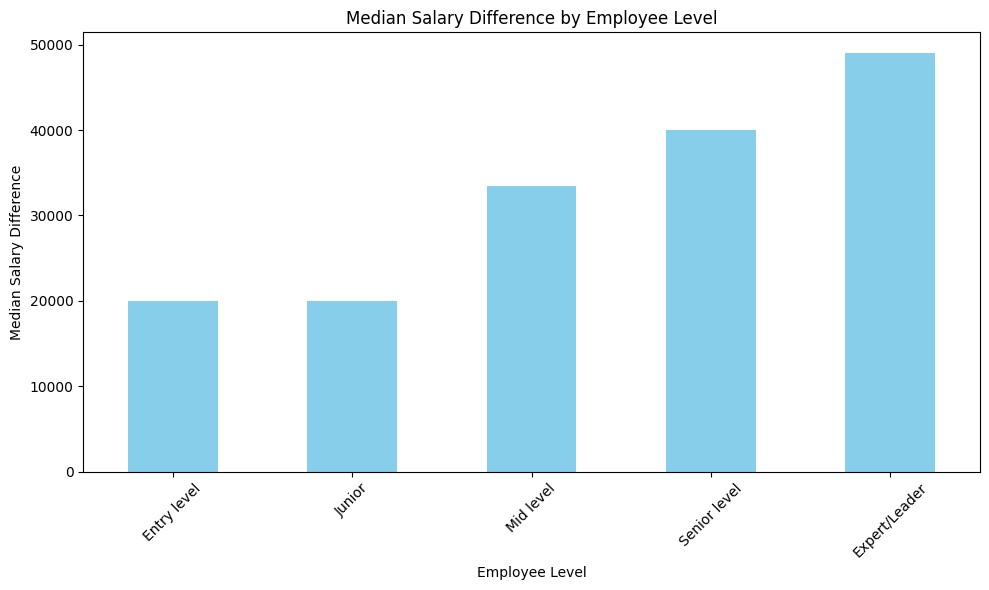

In [36]:
df = data
df['minimum_salary'] = pd.to_numeric(df['minimum_salary'], errors='coerce')
df['max_salary'] = pd.to_numeric(df['max_salary'], errors='coerce')
df['salary_diff'] = df['max_salary'] - df['minimum_salary']

df = df[df['employee_level'] != 'unknown']

plt.figure(figsize=(10, 6))
salary_by_level = df.groupby('employee_level')['salary_diff'].median().sort_values()
salary_by_level.plot(kind='bar', color='skyblue')
plt.title('Median Salary Difference by Employee Level')
plt.ylabel('Median Salary Difference')
plt.xlabel('Employee Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Average Salary Prediction**

In [37]:
data[data['max_salary'] != 'unknown'].count()

,0
job_summary,2290
company_url,2291
job_title,2291
company_title,2291
skills,2291
work_type,2291
minimum_salary,620
max_salary,620
avg_salary,2291
employee_level,2291


# **Average Salary Prediction using TfidVectorized Text information**

In [38]:
data['job_summary'] = data['job_summary'].str.replace(r'\d+', '', regex=True)
data['skills'] = data['skills'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
data = data[data['avg_salary'] != 'unknown']
data['avg_salary'] = pd.to_numeric(data['avg_salary'], errors='coerce')
data = data.dropna(subset=['avg_salary'])

features = ['job_summary', 'job_title', 'company_title', 'skills', 'work_type', 'employee_level']
target = 'avg_salary'

X = data[features]
y = data[target]

X = X.dropna()
y = y.loc[X.index]

one_hot_features = ['work_type', 'employee_level']
tfidf_features = ['job_summary', 'job_title', 'company_title']

mlb = MultiLabelBinarizer()
X_skills = pd.DataFrame(mlb.fit_transform(X['skills']), columns=mlb.classes_, index=X.index)

preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(max_features=100), 'job_summary'),
        ('tfidf_job_title', TfidfVectorizer(max_features=100), 'job_title'),
        ('tfidf_company_title', TfidfVectorizer(max_features=100), 'company_title'),
        ('onehot', OneHotEncoder(handle_unknown='ignore'), one_hot_features)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

X = pd.concat([X.drop(columns='skills'), X_skills], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


<ipython-input-38-26318a8008c6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['avg_salary'] = pd.to_numeric(data['avg_salary'], errors='coerce')


Mean Squared Error: 2056349434.6774194


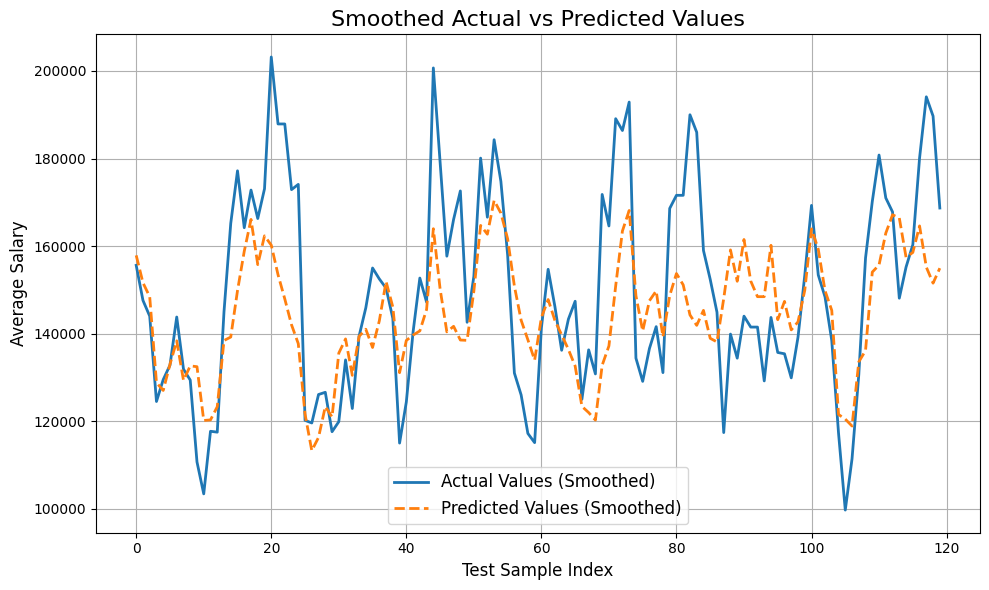

In [39]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 5
y_test_smooth = moving_average(y_test, window_size)
y_pred_smooth = moving_average(y_pred, window_size)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test_smooth)), y_test_smooth, label="Actual Values (Smoothed)", linestyle='-', linewidth=2)
plt.plot(np.arange(len(y_pred_smooth)), y_pred_smooth, label="Predicted Values (Smoothed)", linestyle='--', linewidth=2)
plt.title("Smoothed Actual vs Predicted Values", fontsize=16)
plt.xlabel("Test Sample Index", fontsize=12)
plt.ylabel("Average Salary", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Between the ranges of 120,000 and 160,000, the model somewhat follows the trend, but it struggles to predict actual values accurately beyond these boundaries. This indicates potential limitations in the dataset and feature representation. The average salary dataset is insufficient, and most other features are textual, making them less suitable for accurate salary prediction.

Additionally:
	1.	Feature Count: The features are limited in number and lack diversity.
	2.	Label Quality: The target variable (average salary) has too many null values, compromising the quality of supervised learning.

Given these constraints, unsupervised machine learning through clustering seems more appropriate. By grouping similar data points, we can focus on providing job and skill recommendations based on clusters, aligning better with the dataset’s strengths.

First Preprocess the data to reduce the noise

In [40]:
def preprocess_text(text):
    if isinstance(text, pd.Series):
        return text.str.lower().str.replace(r"[^a-z0-9, ]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
    elif isinstance(text, str):
        text = text.lower()
        text = re.sub(r"[^a-z0-9, ]", "", text)
        text = re.sub(r"\s+", " ", text).strip()
        return text
    return text

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().lower().replace("_", " "))
    return synonyms

def replace_with_synonyms(text):
    words = text.lower().split()
    replaced_words = []
    for word in words:
        synonyms = get_synonyms(word)
        if synonyms:
            replaced_words.append(list(synonyms)[0])
        else:
            replaced_words.append(word)
    return " ".join(replaced_words)

def correct_spelling(input_skills, skill_list):
    corrected_skills = []
    for skill in input_skills.split(","):
        skill = skill.strip()
        if not skill:
            continue
        match = process.extractOne(skill, skill_list, scorer=fuzz.ratio)
        if match and match[1] > 80:
            corrected_skills.append(match[0])
        else:
            corrected_skills.append(skill)
    return ", ".join(corrected_skills)

def preprocess_skills_column(skills_column):
    all_skills = []
    for skills in skills_column.dropna():
        try:
            skills_list = ast.literal_eval(skills)
            all_skills.extend(skill.strip().lower() for skill in skills_list)
        except (ValueError, SyntaxError):
            continue
    return sorted(set(all_skills))

def preprocess_and_correct_skills(skills_column, skill_list):
    processed_skills = []
    for skills in skills_column.dropna():

        if isinstance(skills, list):
            skills = ' '.join(skills)
        skills = preprocess_text(skills)
        skills = replace_with_synonyms(skills)
        skills = correct_spelling(skills, skill_list)
        processed_skills.append(skills)
    return processed_skills

TF_IDF_Embedding

In [41]:
skill_list = preprocess_skills_column(data['skills'])

data['skills'] = preprocess_and_correct_skills(data['skills'], skill_list)
data['combined_text'] = (
    data['job_summary'].fillna('').apply(preprocess_text) + ' ' +
    data['job_title'].fillna('').apply(preprocess_text) + ' ' +
    data['skills'].fillna('') + ' ' +
    data['work_type'].fillna('').apply(preprocess_text) + ' ' +
    data['employee_level'].fillna('').apply(preprocess_text)
)

vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(data['combined_text'])

kmeans = KMeans(n_clusters=10, random_state=42)
data['cluster'] = kmeans.fit_predict(tfidf_matrix)

## Find out what is the best cluster size

Elbow Method for TF-IDF embedding

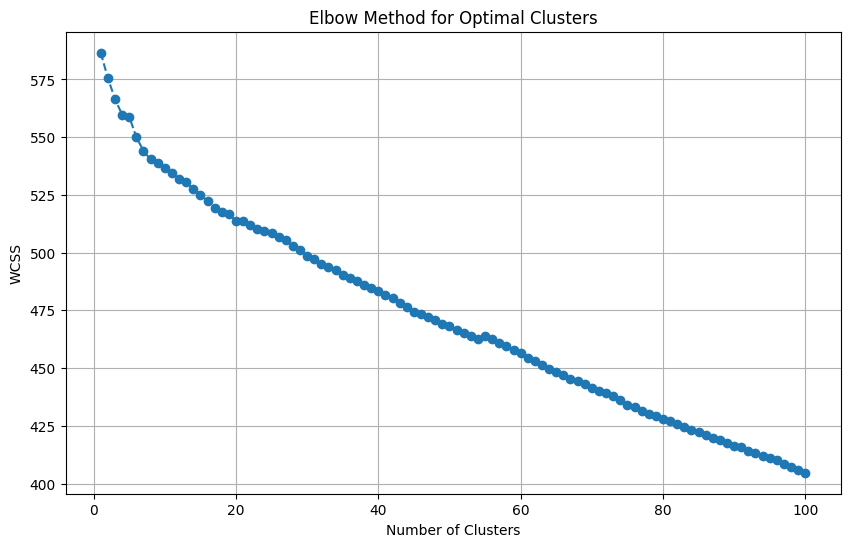

In [42]:
wcss = []
max_clusters = 100

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

Silhouette Score for TF-IDF embedding

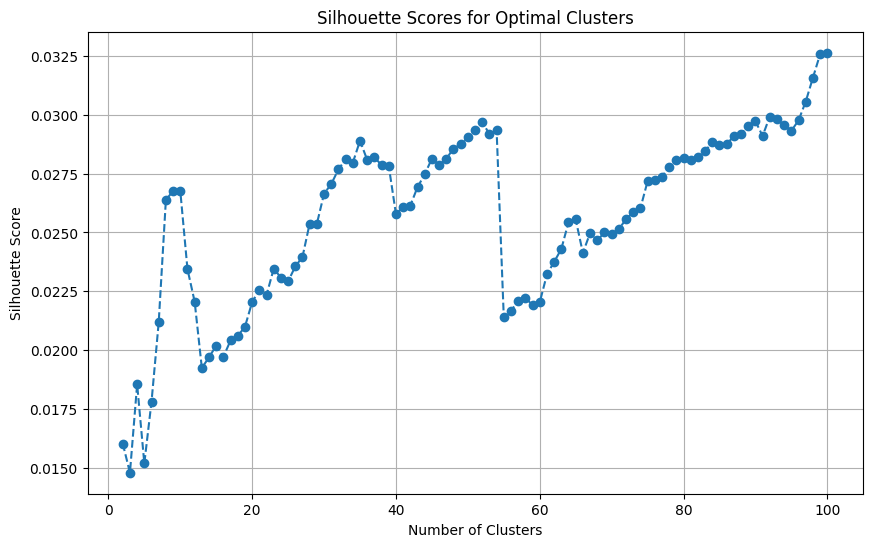

In [43]:
silhouette_scores = []

for i in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Scores for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

Defining 50 as cluster size seems reasonable for TF-IDF embedding

In [44]:
num_clusters = 50
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(tfidf_matrix)

print(data[['job_title', 'skills', 'cluster']].head())

                                job_title  \
3                  Implementation Manager   
5                         DevOps Engineer   
6                            iOS Engineer   
7  Senior WebRTC QA & Automation Engineer   
8          Senior Sage Intacct Consultant   

                                              skills  cluster  
3  cesium hypertext mark-up language liquid crims...       26  
5                           spell python crimson sql       45  
6                            sceloporus occidentalis       30  
7                  dramatist atomic number 34 webrtc       15  
8                                       sage intacct       18  


Davies_bouldin Score

In [45]:
db_index = davies_bouldin_score(tfidf_matrix.toarray(), data['cluster'])
print(f"Davies-Bouldin Index for {num_clusters} clusters: {db_index}")

Davies-Bouldin Index for 50 clusters: 3.385551463643597


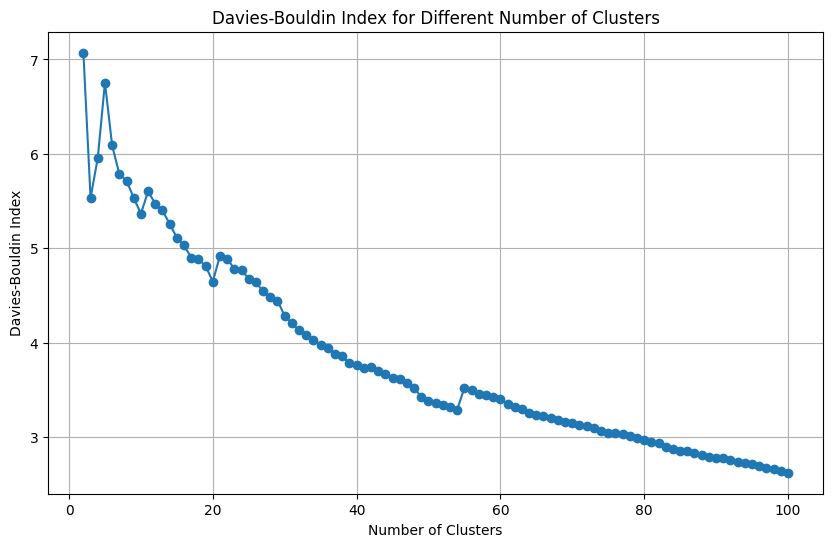

In [46]:
db_scores = []
cluster_range = range(2, 101)

for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(tfidf_matrix)
    db_index = davies_bouldin_score(tfidf_matrix.toarray(), labels)
    db_scores.append(db_index)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, db_scores, marker='o')
plt.title("Davies-Bouldin Index for Different Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.grid()
plt.show()

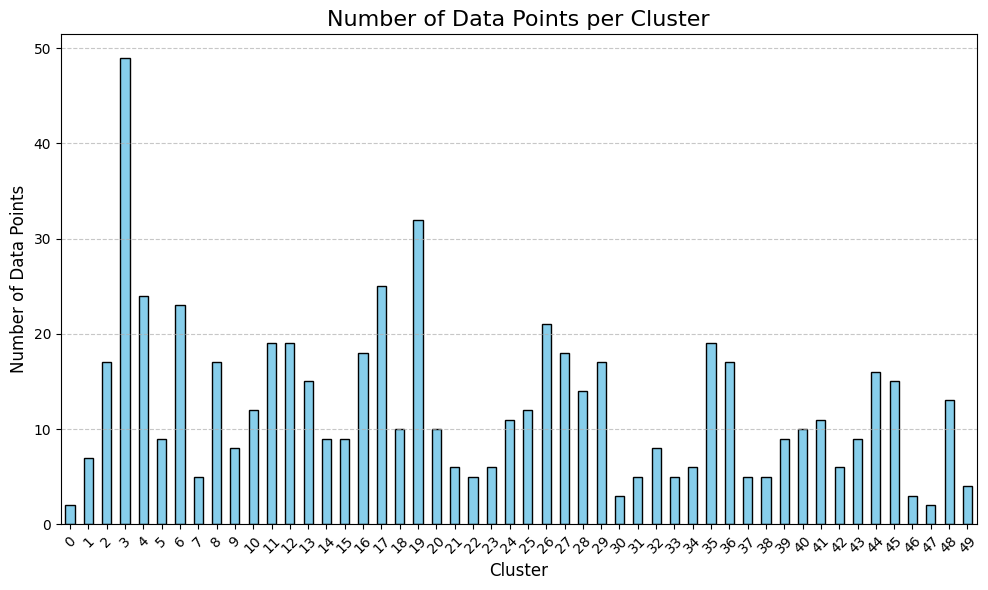

In [47]:
cluster_counts = data['cluster'].value_counts()

plt.figure(figsize=(10, 6))
cluster_counts.sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Data Points per Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Data Points', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [48]:
centroids = kmeans.cluster_centers_

terms = vectorizer.get_feature_names_out()
for i, centroid in enumerate(centroids):
    print(f"Cluster {i} top terms:")
    sorted_terms = centroid.argsort()[::-1]
    for term_idx in sorted_terms[:5]:
        print(f" - {terms[term_idx]}")
    print()

Cluster 0 top terms:
 - sales
 - revenuecat
 - revenuecats
 - onboard
 - sceloporus

Cluster 1 top terms:
 - software
 - perception
 - engineer
 - staff
 - research

Cluster 2 top terms:
 - marketing
 - paid
 - media
 - social
 - growth

Cluster 3 top terms:
 - data
 - sql
 - engineer
 - analytics
 - senior

Cluster 4 top terms:
 - solutions
 - custom
 - customer
 - engineer
 - challenges

Cluster 5 top terms:
 - sales
 - midmarket
 - saas
 - account
 - customer

Cluster 6 top terms:
 - sales
 - operations
 - commission
 - manager
 - crm

Cluster 7 top terms:
 - product
 - management
 - nurse
 - utilization
 - starburst

Cluster 8 top terms:
 - product
 - principal
 - manager
 - database
 - personalization

Cluster 9 top terms:
 - accounting
 - accountant
 - financial
 - close
 - controller

Cluster 10 top terms:
 - engineering
 - positive
 - team
 - package
 - manager

Cluster 11 top terms:
 - product
 - graph
 - productivity
 - engineer
 - backend

Cluster 12 top terms:
 - qa
 - test

Showing how the Cluster gathered like: PCA(Linear)

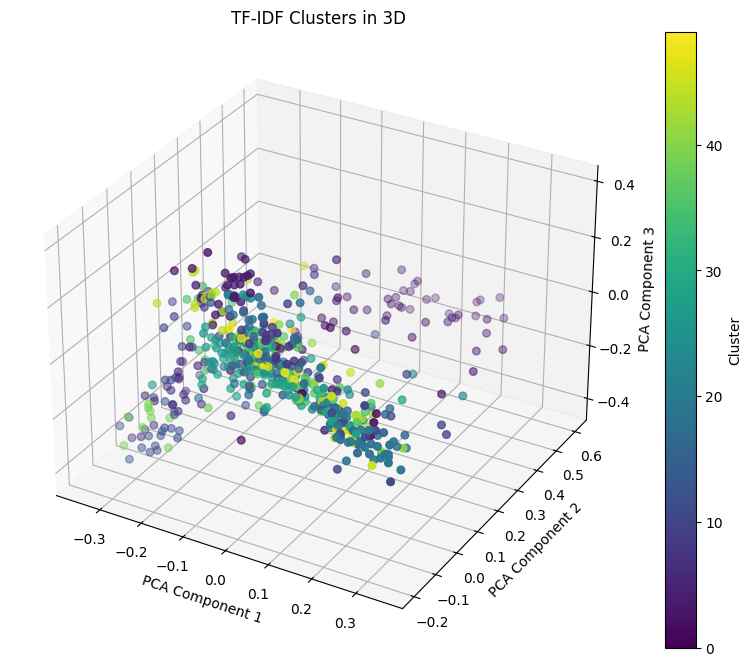

In [49]:
pca = PCA(n_components=3)
reduced_data_3d = pca.fit_transform(tfidf_matrix.toarray())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    reduced_data_3d[:, 0], reduced_data_3d[:, 1], reduced_data_3d[:, 2],
    c=data['cluster'], cmap='viridis', s=30
)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Cluster")

ax.set_title("TF-IDF Clusters in 3D")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")

plt.show()

Showing how the Cluster gathered like: TSNE(Nonlinear)

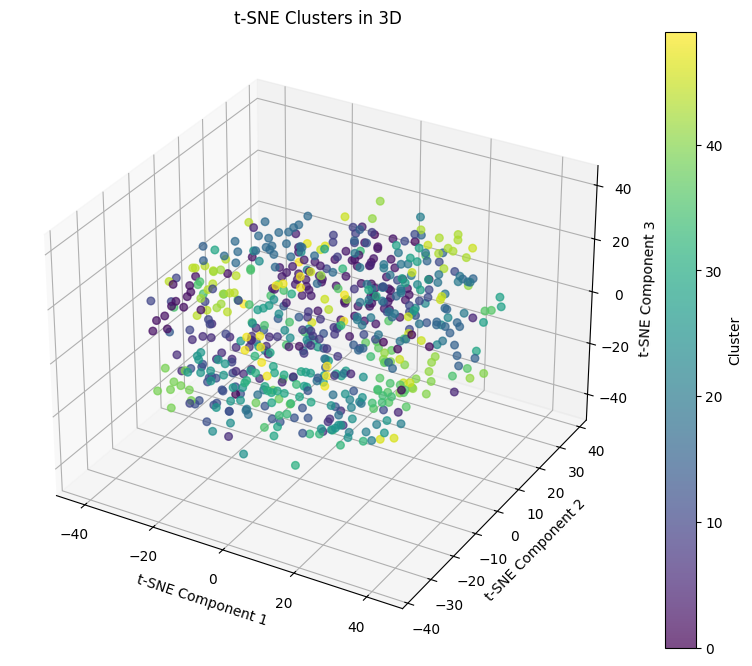

In [50]:
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
reduced_data_tsne = tsne.fit_transform(tfidf_matrix.toarray())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], reduced_data_tsne[:, 2],
    c=data['cluster'], cmap='viridis', s=30, alpha=0.7
)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Cluster")

ax.set_title("t-SNE Clusters in 3D")
ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_zlabel("t-SNE Component 3")

plt.show()

What does te cluster contains? Let's check Cluster 6

In [51]:
print("Data in Cluster 6:")
cluster_6_data = data[data['cluster'] == 6]
print(cluster_6_data[['job_title', 'skills']].head())

print(f"Number of data points in Cluster 6: {len(cluster_6_data)}")

Data in Cluster 6:
                                      job_title  \
57                        RVP, Mid-Market Sales   
75                     Sales Operations Analyst   
77   Business Operations Director, Global Sales   
206          Channel Partner GTM Representative   
301                    Head of Sales Operations   

                                                skills  
57                                           itsm saas  
75                                        sfdc tableau  
77   bradypus tridactylus automobile instruct sales...  
206                                         salesforce  
301                                                crm  
Number of data points in Cluster 6: 23


Job and SKill recommendation system

The Job and Skill Recommendation System helps users explore relevant job roles and skills by matching their input with pre-clustered job and skill data. It identifies gaps in the user’s skill set.

In [52]:
def find_closest_cluster(input_title, input_skills, input_level, data, vectorizer, kmeans):

    user_input = f"{input_title} {input_skills} {input_level}"

    user_vector = vectorizer.transform([user_input])

    cluster_similarities = cosine_similarity(user_vector, kmeans.cluster_centers_)
    closest_cluster_id = cluster_similarities.argmax()
    similarity_score = cluster_similarities[0][closest_cluster_id]

    return closest_cluster_id, similarity_score

Making the Recommendation System based on Doc2Vec Embedding

In [53]:
skill_list = preprocess_skills_column(data['skills'])

data['skills'] = preprocess_and_correct_skills(data['skills'], skill_list)
data['combined_text'] = (
    data['job_summary'].fillna('').apply(preprocess_text) + ' ' +
    data['job_title'].fillna('').apply(preprocess_text) + ' ' +
    data['skills'].fillna('') + ' ' +
    data['work_type'].fillna('').apply(preprocess_text) + ' ' +
    data['employee_level'].fillna('').apply(preprocess_text)
)

documents = [TaggedDocument(doc.split(), [i]) for i, doc in enumerate(data['combined_text'])]
model = Doc2Vec(documents, vector_size=100, window=5, min_count=2, workers=4)
data['doc2vec_embedding'] = [model.infer_vector(doc.split()) for doc in data['combined_text']]

doc2vec_matrix = np.array(data['doc2vec_embedding'].tolist())

# 7 clusters
kmeans = KMeans(n_clusters=7, random_state=42)
data['cluster'] = kmeans.fit_predict(doc2vec_matrix)

print("Cluster labels assigned to data:")
print(data['cluster'].value_counts())

Cluster labels assigned to data:
cluster
4    142
0    123
2     93
5     90
3     68
6     65
1     39
Name: count, dtype: int64


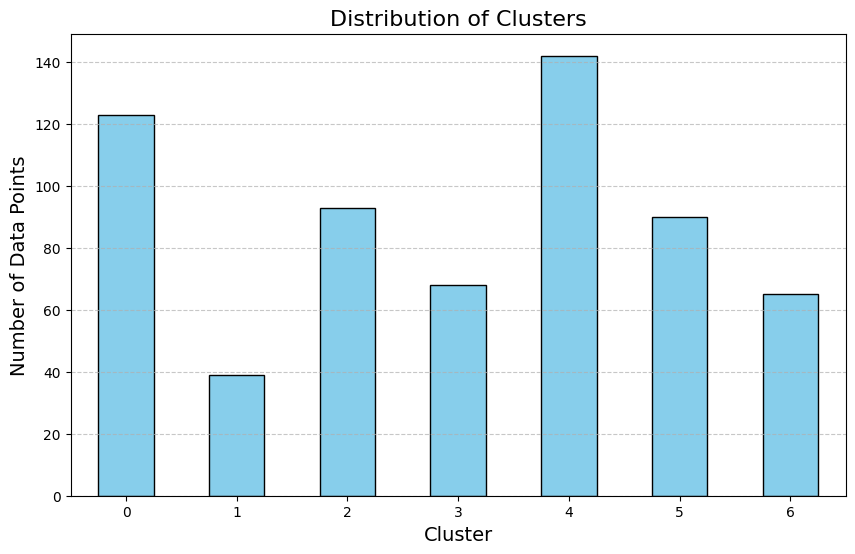

In [54]:
plt.figure(figsize=(10, 6))
data['cluster'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution of Clusters", fontsize=16)
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Number of Data Points", fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [55]:
for cluster_id in sorted(data['cluster'].unique()):
    print(f"\nCluster {cluster_id}:\n" + "-" * 30)

    cluster_data = data[data['cluster'] == cluster_id]
    jobs = cluster_data['job_title'].tolist()
    skills = cluster_data['skills'].tolist()

    print(f"Number of Jobs: {len(jobs)}")
    print(f"Sample Jobs: {', '.join(jobs[:5])}")
    print(f"Common Skills in this Cluster:")

    skill_counts = {}
    for skill_list in skills:
        for skill in skill_list.split(','):
            skill = skill.strip().lower()
            skill_counts[skill] = skill_counts.get(skill, 0) + 1

    sorted_skills = sorted(skill_counts.items(), key=lambda x: x[1], reverse=True)[:5]  # Top 5 skills
    for skill, count in sorted_skills:
        print(f"- {skill}: {count}")


Cluster 0:
------------------------------
Number of Jobs: 123
Sample Jobs: Enterprise Account Executive, Life Sciences, Senior Software Engineer, Senior Account Executive, Large Enterprise - Remote, Digital Account Strategist, Content Marketing Specialist
Common Skills in this Cluster:
- python: 6
- coke: 4
- python sql: 4
- genus bradypus tridactylus: 3
- javascript react: 3

Cluster 1:
------------------------------
Number of Jobs: 39
Sample Jobs: Senior AI Engineer - Principal Associate, In Vitro Biologist/Molecular Pharmacologist, Insights & Measurement Specialist, Advertising Sales, Product Owner - Remote, Identity and Access Management Privilege Access Management Specialist - AVP
Common Skills in this Cluster:
- genus bradypus tridactylus aws huggingface cc nemo guardrail pytorch vectordbs: 1
- biochemistry molecular pharmacology: 1
- consultation one-sixth sentience safari measuring data point full stop profoundness psychological science: 1
- spry: 1
- powershell python sql: 1


In [56]:
def recommend_with_doc2vec(input_title, input_skills, input_level, data, model, kmeans, num_recommendations=5, top_skills=5):
    user_input = f"{input_title} {input_skills} {input_level}"
    user_vector = model.infer_vector(user_input.split()).reshape(1, -1)

    cluster_similarities = cosine_similarity(user_vector, kmeans.cluster_centers_)
    closest_cluster_id = cluster_similarities.argmax()
    similarity_score = cluster_similarities[0][closest_cluster_id]

    cluster_data = data[data['cluster'] == closest_cluster_id]

    if cluster_data.empty:
        return {
            'message': f"No jobs found in cluster {closest_cluster_id}. Try different inputs.",
            'Recommended Jobs': [],
            'Missing Skills': [],
        }

    cluster_data = cluster_data.sample(frac=1, random_state=42)
    recommended_jobs = cluster_data[['job_title', 'skills']].drop_duplicates().head(num_recommendations)

    # Collect all skills from the cluster
    all_skills = []
    for skills in cluster_data['skills']:
        if isinstance(skills, str) and skills.strip():
            all_skills.extend(skill.strip().lower() for skill in skills.split(","))
        else:
            print(f"Invalid or empty skills: {skills}")  # Debugging

    print(f"All skills in cluster: {all_skills}")  # Debugging

    # Process user skills
    user_skills = {skill.strip().lower() for skill in input_skills.split(",") if skill.strip()}
    print(f"User skills: {user_skills}")  # Debugging

    # Find missing skills
    all_skills_counter = Counter(all_skills)
    missing_skills = {skill: count for skill, count in all_skills_counter.items() if skill and skill not in user_skills}

    if not missing_skills:
        print("No missing skills detected.")  # Debugging

    sorted_missing_skills = sorted(missing_skills.items(), key=lambda item: item[1], reverse=True)[:top_skills]

    return {
        'message': f"Closest cluster: {closest_cluster_id}, similarity score: {similarity_score:.2f}",
        'Recommended Jobs': recommended_jobs.to_dict(orient='records'),
        'Missing Skills': [{'skill': skill, 'count': count} for skill, count in sorted_missing_skills],
    }

# **Job and Missing Skills return GUI**

In [57]:
def main():
    print("Welcome to the Job and Skill Recommendation System!")

    input_title = input("Enter your wanted job title (e.g., Data Analyst): ").strip()
    input_skills = input("Enter your current skills (comma-separated, e.g., Python, SQL): ").strip()

    levels = ["Entry-Level", "Mid-Level", "Senior-Level", "Executive"]
    print("\nChoose your employee level:")
    for i, level in enumerate(levels, 1):
        print(f"{i}. {level}")

    while True:
        try:
            level_choice = int(input("Enter the number corresponding to your level (e.g., 1 for Entry-Level): ").strip())
            if 1 <= level_choice <= len(levels):
                input_level = levels[level_choice - 1]
                break
            else:
                print("Invalid number. Please enter a number between 1 and 4.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")

    print("\nCalculating recommendations...\n")

    recommendations = recommend_with_doc2vec(
        input_title=input_title,
        input_skills=input_skills,
        input_level=input_level,
        data=data,
        model=model,
        kmeans=kmeans
    )

    print(recommendations['message'])
    print("\nRecommended Jobs:")
    if recommendations['Recommended Jobs']:
        for job in recommendations['Recommended Jobs']:
            print(f"- Job Title: {job['job_title']}, Required Skills: {job['skills']}")
    else:
        print("No recommended jobs found.")

    print("\nMissing Skills:")
    if recommendations['Missing Skills']:
        print("Top 5 Missing Skills:")
        for skill in recommendations['Missing Skills']:
            print(f"- {skill}")
    else:
        print("No missing skills found.")
if __name__ == "__main__":
    main()


Welcome to the Job and Skill Recommendation System!
Enter your wanted job title (e.g., Data Analyst): data scientist
Enter your current skills (comma-separated, e.g., Python, SQL): python

Choose your employee level:
1. Entry-Level
2. Mid-Level
3. Senior-Level
4. Executive
Enter the number corresponding to your level (e.g., 1 for Entry-Level): 3

Calculating recommendations...

All skills in cluster: ['python django react', 'coke coke spell umber eat', 'python', 'spry scrum', 'tainted saas', 'automobile instruct package', 'cch metre authorisation', 'python sql', 'nodejs python typescript', 'coke cesium hypertext markup spoken communication umber javascript nodejs react typescript', 'sql', 'react violent', 'spell umber nodejs violent', 'powershell', 'spell typescript', 'spell nodejs python', 'coke', 'sql', 'package engineering', 'spell nodejs python react', 'spell python', 'python', 'violent', 'cybersecurity', 'coke spell umber python', 'genus bradypus tridactylus mlops', 'graphql nodej

# **comparing different embedding and finding optimal  n cluster**

In [58]:
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(data['combined_text'])

kmeans_tfidf = KMeans(n_clusters=7, random_state=42)
data['cluster_tfidf'] = kmeans_tfidf.fit_predict(tfidf_matrix)

silhouette_tfidf = silhouette_score(tfidf_matrix, data['cluster_tfidf'])
davies_bouldin_tfidf = davies_bouldin_score(tfidf_matrix.toarray(), data['cluster_tfidf'])

print(f"TF-IDF Silhouette Score: {silhouette_tfidf}")
print(f"TF-IDF Davies-Bouldin Index: {davies_bouldin_tfidf}")

doc2vec_matrix = np.array(data['doc2vec_embedding'].tolist())

kmeans_doc2vec = KMeans(n_clusters=10, random_state=42)
data['cluster_doc2vec'] = kmeans_doc2vec.fit_predict(doc2vec_matrix)

silhouette_doc2vec = silhouette_score(doc2vec_matrix, data['cluster_doc2vec'])
davies_bouldin_doc2vec = davies_bouldin_score(doc2vec_matrix, data['cluster_doc2vec'])

print(f"Doc2Vec Silhouette Score: {silhouette_doc2vec}")
print(f"Doc2Vec Davies-Bouldin Index: {davies_bouldin_doc2vec}")

TF-IDF Silhouette Score: 0.021600784855154594
TF-IDF Davies-Bouldin Index: 5.796133903517633
Doc2Vec Silhouette Score: 0.2230939269065857
Doc2Vec Davies-Bouldin Index: 1.1913492009785818


Comparing visualized cluster's space (PCA)

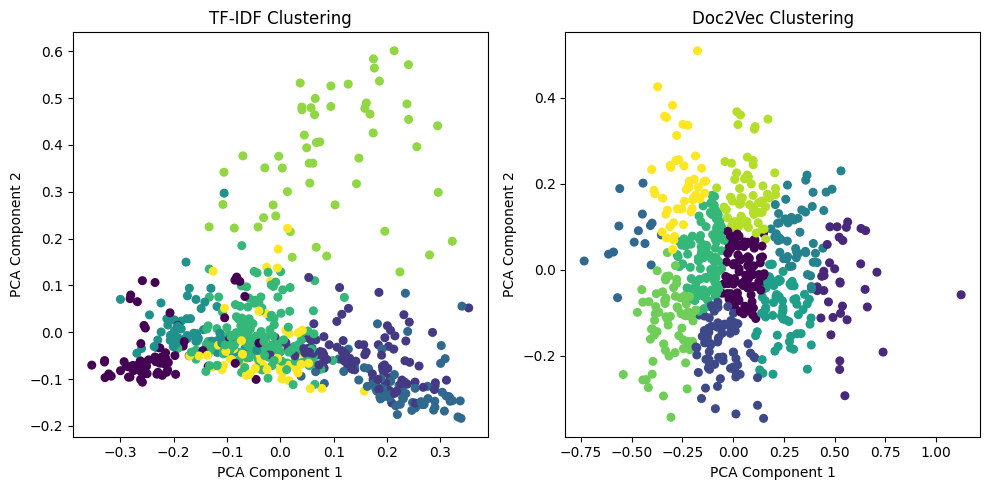

In [59]:
pca_tfidf = PCA(n_components=2)
reduced_tfidf = pca_tfidf.fit_transform(tfidf_matrix.toarray())

pca_doc2vec = PCA(n_components=2)
reduced_doc2vec = pca_doc2vec.fit_transform(doc2vec_matrix)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(reduced_tfidf[:, 0], reduced_tfidf[:, 1], c=data['cluster_tfidf'], cmap='viridis', s=30)
plt.title("TF-IDF Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.subplot(1, 2, 2)
plt.scatter(reduced_doc2vec[:, 0], reduced_doc2vec[:, 1], c=data['cluster_doc2vec'], cmap='viridis', s=30)
plt.title("Doc2Vec Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.tight_layout()
plt.show()

Comparing visualized cluster's space (TSNE)

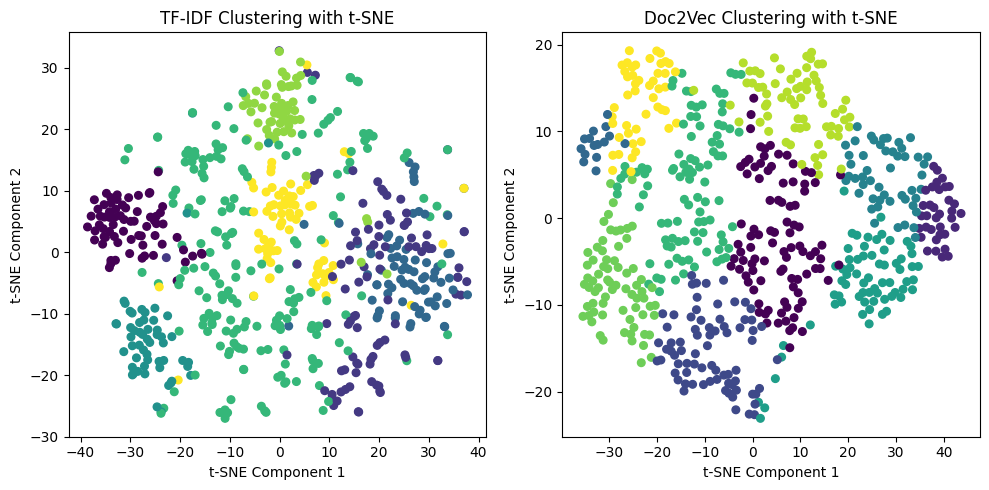

In [60]:
tsne_tfidf = TSNE(n_components=2, random_state=42)
reduced_tfidf_tsne = tsne_tfidf.fit_transform(tfidf_matrix.toarray())

tsne_doc2vec = TSNE(n_components=2, random_state=42)
reduced_doc2vec_tsne = tsne_doc2vec.fit_transform(doc2vec_matrix)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(reduced_tfidf_tsne[:, 0], reduced_tfidf_tsne[:, 1], c=data['cluster_tfidf'], cmap='viridis', s=30)
plt.title("TF-IDF Clustering with t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

plt.subplot(1, 2, 2)
plt.scatter(reduced_doc2vec_tsne[:, 0], reduced_doc2vec_tsne[:, 1], c=data['cluster_doc2vec'], cmap='viridis', s=30)
plt.title("Doc2Vec Clustering with t-SNE")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

plt.tight_layout()
plt.show()

Bert Embedding

Hugging face token setting is needed to run the code

In [ ]:
from huggingface_hub import login

login("your_hugging_face_token_here")

In [61]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = sbert_model.encode(data['combined_text'].tolist(), show_progress_bar=True)

sbert_matrix = np.array(embeddings)

print(f"Shape of SBERT embeddings: {sbert_matrix.shape}")

kmeans_sbert = KMeans(n_clusters=10, random_state=42)
data['cluster_sbert'] = kmeans_sbert.fit_predict(sbert_matrix)

print("Cluster labels assigned to data:")
print(data['cluster_sbert'].value_counts())

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Shape of SBERT embeddings: (620, 384)
Cluster labels assigned to data:
cluster_sbert
1    91
7    85
0    75
4    72
5    71
9    60
2    52
6    43
3    40
8    31
Name: count, dtype: int64


n_clusters: 2 | Silhouette Score: 0.06 | Davies-Bouldin Index: 3.82
n_clusters: 3 | Silhouette Score: 0.05 | Davies-Bouldin Index: 4.40
n_clusters: 4 | Silhouette Score: 0.05 | Davies-Bouldin Index: 3.95
n_clusters: 5 | Silhouette Score: 0.05 | Davies-Bouldin Index: 3.87
n_clusters: 6 | Silhouette Score: 0.04 | Davies-Bouldin Index: 3.88
n_clusters: 7 | Silhouette Score: 0.04 | Davies-Bouldin Index: 4.11
n_clusters: 8 | Silhouette Score: 0.04 | Davies-Bouldin Index: 4.06
n_clusters: 9 | Silhouette Score: 0.04 | Davies-Bouldin Index: 3.80
n_clusters: 10 | Silhouette Score: 0.03 | Davies-Bouldin Index: 3.94
n_clusters: 11 | Silhouette Score: 0.04 | Davies-Bouldin Index: 3.67
n_clusters: 12 | Silhouette Score: 0.04 | Davies-Bouldin Index: 3.59
n_clusters: 13 | Silhouette Score: 0.04 | Davies-Bouldin Index: 3.58
n_clusters: 14 | Silhouette Score: 0.04 | Davies-Bouldin Index: 3.53
n_clusters: 15 | Silhouette Score: 0.04 | Davies-Bouldin Index: 3.51
n_clusters: 16 | Silhouette Score: 0.04 | 

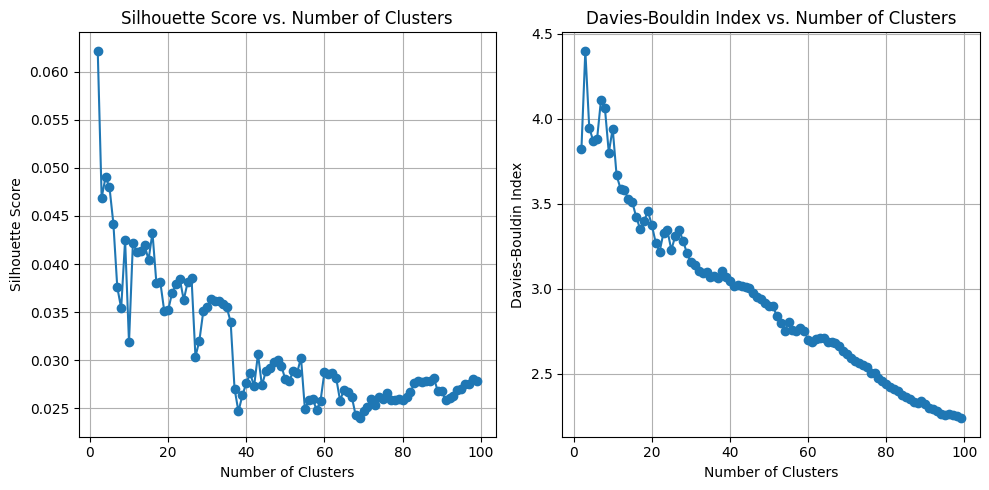

In [62]:
n_clusters_range = range(2, 100)

silhouette_scores = []
davies_bouldin_scores = []

for n_clusters in n_clusters_range:

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(sbert_matrix)

    silhouette = silhouette_score(sbert_matrix, cluster_labels)
    davies_bouldin = davies_bouldin_score(sbert_matrix, cluster_labels)

    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)

    print(f"n_clusters: {n_clusters} | Silhouette Score: {silhouette:.2f} | Davies-Bouldin Index: {davies_bouldin:.2f}")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(n_clusters_range, davies_bouldin_scores, marker='o')
plt.title("Davies-Bouldin Index vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Davies-Bouldin Index")
plt.grid(True)

plt.tight_layout()
plt.show()

Comparing TF_IDF, DOC2VEC, SBERT embedding

TF-IDF - Silhouette Score: 0.02, Davies-Bouldin Index: 5.80
Doc2Vec - Silhouette Score: 0.22, Davies-Bouldin Index: 1.19
SBERT - Silhouette Score: 0.03, Davies-Bouldin Index: 3.94


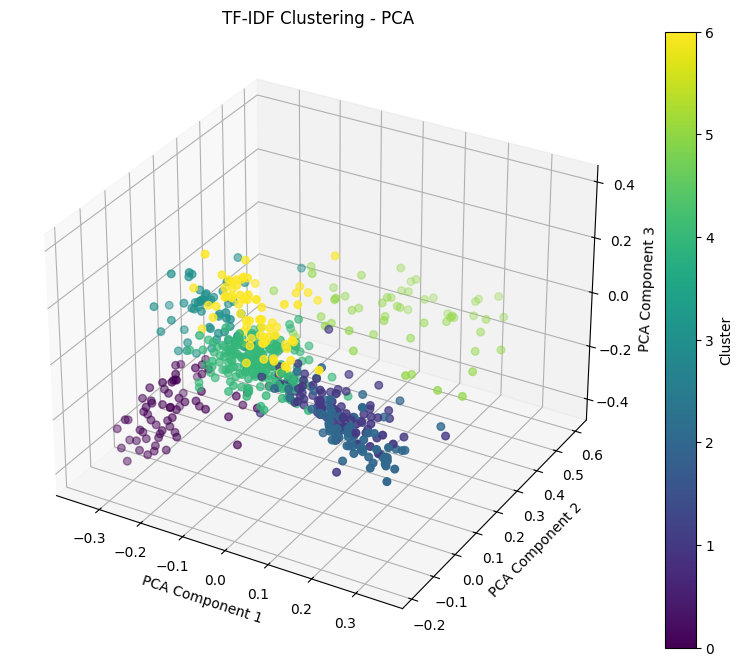

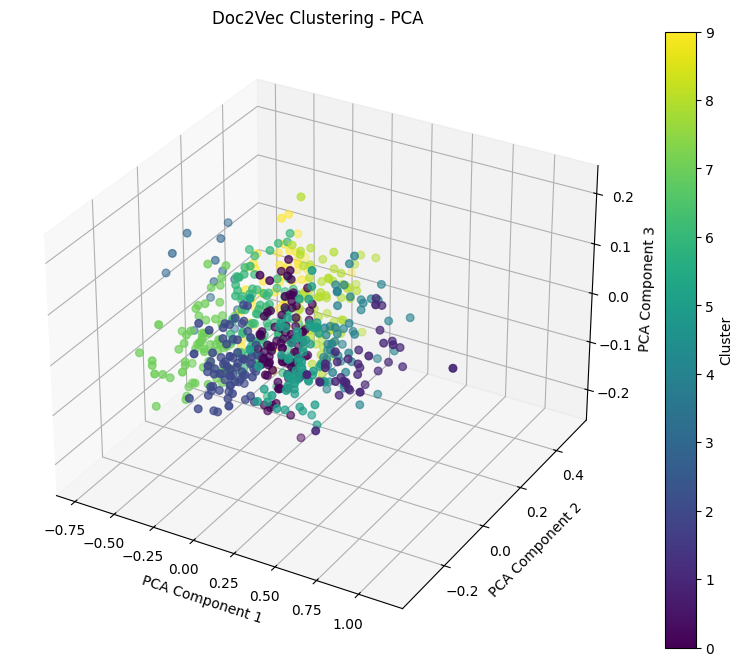

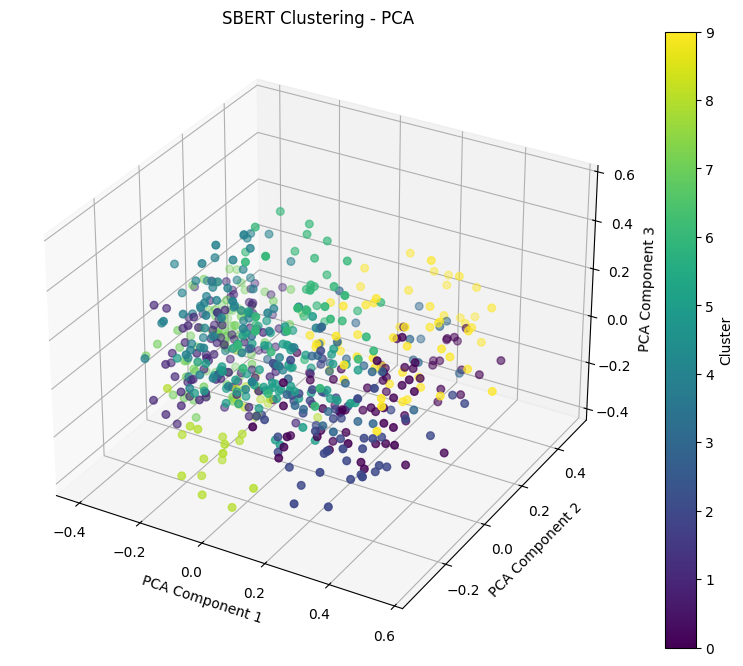

In [63]:
def evaluate_clustering(matrix, labels, method_name):
    silhouette = silhouette_score(matrix, labels)
    davies_bouldin = davies_bouldin_score(matrix, labels)
    print(f"{method_name} - Silhouette Score: {silhouette:.2f}, Davies-Bouldin Index: {davies_bouldin:.2f}")
    return silhouette, davies_bouldin

silhouette_tfidf, davies_bouldin_tfidf = evaluate_clustering(tfidf_matrix.toarray(), data['cluster_tfidf'], "TF-IDF")
silhouette_doc2vec, davies_bouldin_doc2vec = evaluate_clustering(doc2vec_matrix, data['cluster_doc2vec'], "Doc2Vec")
silhouette_sbert, davies_bouldin_sbert = evaluate_clustering(sbert_matrix, data['cluster_sbert'], "SBERT")

def visualize_clusters(matrix, labels, method_name, reduction='PCA', dimensions=2):
    if reduction == 'PCA':
        reducer = PCA(n_components=dimensions)
    elif reduction == 't-SNE':
        reducer = TSNE(n_components=dimensions, random_state=42)
    else:
        raise ValueError("Reduction must be 'PCA' or 't-SNE'")

    reduced_data = reducer.fit_transform(matrix)

    if dimensions == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', s=30)
        plt.title(f"{method_name} Clustering - {reduction}")
        plt.xlabel(f"{reduction} Component 1")
        plt.ylabel(f"{reduction} Component 2")
        plt.colorbar(label="Cluster")
        plt.grid(True)
        plt.show()
    elif dimensions == 3:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=labels, cmap='viridis', s=30)
        ax.set_title(f"{method_name} Clustering - {reduction}")
        ax.set_xlabel(f"{reduction} Component 1")
        ax.set_ylabel(f"{reduction} Component 2")
        ax.set_zlabel(f"{reduction} Component 3")
        plt.colorbar(scatter, ax=ax, label="Cluster")
        plt.show()

# Visualize TF-IDF
visualize_clusters(tfidf_matrix.toarray(), data['cluster_tfidf'], "TF-IDF", reduction='PCA', dimensions=3)
# Visualize Doc2Vec
visualize_clusters(doc2vec_matrix, data['cluster_doc2vec'], "Doc2Vec", reduction='PCA', dimensions=3)
# Visualize SBERT
visualize_clusters(sbert_matrix, data['cluster_sbert'], "SBERT", reduction='PCA', dimensions=3)

DATA in DOC2VEC cluster 6

In [64]:
print("Data in Cluster 6:")
cluster_6_data = data[data['cluster_doc2vec'] == 6]
print(cluster_6_data[['job_title', 'skills']].head())

print(f"Number of data points in Cluster 6: {len(cluster_6_data)}")

Data in Cluster 6:
                                      job_title  \
17        Business Information Security Officer   
20   Corporate Account Manager, Brazil (Remote)   
23     Senior Public Cloud Solutions Consultant   
24                       Firmware Engineer(C++)   
40  Digital Contact & Services Senior Associate   

                                               skills  
17         cybersecurity technology hazard management  
20                                       tainted saas  
23                                 aws skyblue google  
24                              coke spell python eat  
40  data point full stop utilization data point fu...  
Number of data points in Cluster 6: 99


DATA in Sentence bert cluster 6

In [65]:
print("Data in Cluster 6:")
cluster_6_data = data[data['cluster_sbert'] == 6]
print(cluster_6_data[['job_title', 'skills']].head())

print(f"Number of data points in Cluster 6: {len(cluster_6_data)}")

Data in Cluster 6:
                                             job_title  \
27   Senior Business Intelligence Analyst, Revenue ...   
37                     Senior Customer Success Analyst   
72                 Merchant Payment Processing Analyst   
75                            Sales Operations Analyst   
176                                        SEO Analyst   

                                                skills  
27                                          python sql  
37                                             stunner  
72                                          python sql  
75                                        sfdc tableau  
176  cesium hypertext markup spoken communication j...  
Number of data points in Cluster 6: 43


Finding the fitted number of the cluster for Doc2Vec Embedding

Elbow Method (Doc2vec)

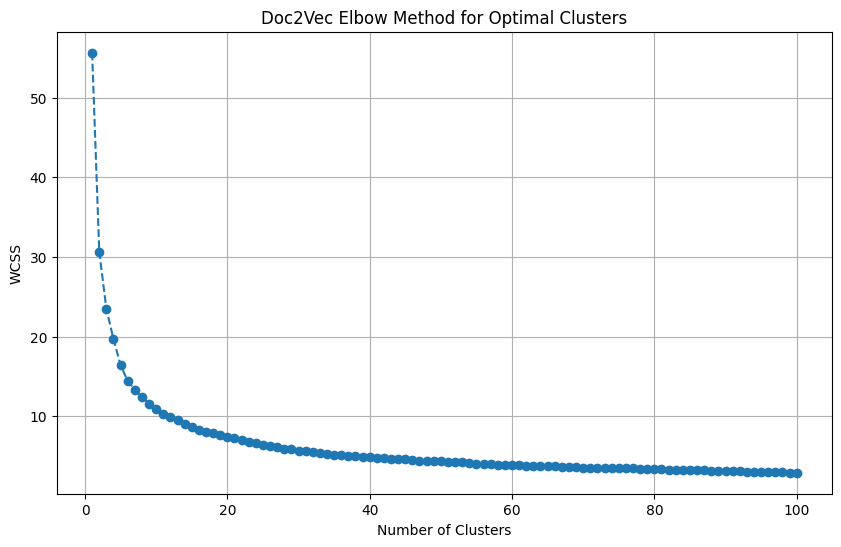

In [67]:
wcss = []
max_clusters = 100

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(doc2vec_matrix)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Doc2Vec Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

Silhouette score (Doc2vec)

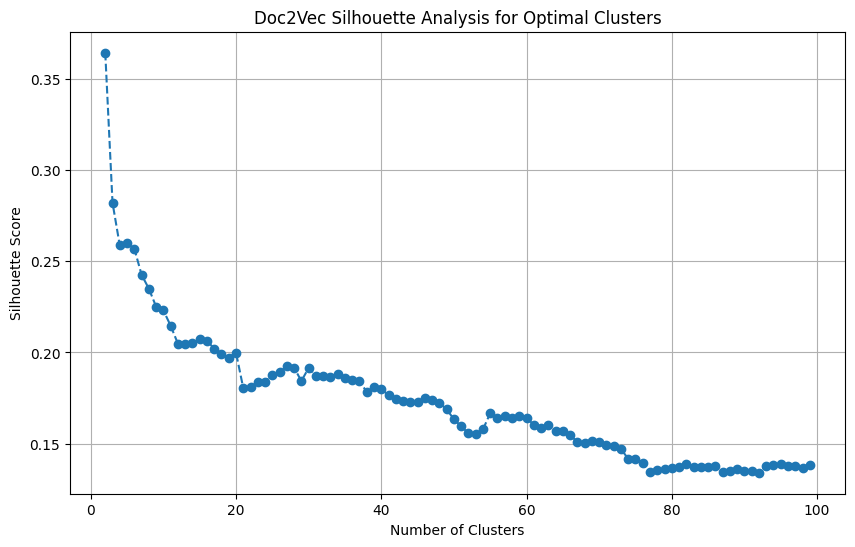

In [68]:
silhouette_scores = []
cluster_range = range(2, 100)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(doc2vec_matrix)
    silhouette_avg = silhouette_score(doc2vec_matrix, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--')
plt.title('Doc2Vec Silhouette Analysis for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

Davies Bouldin score (Doc2vec)

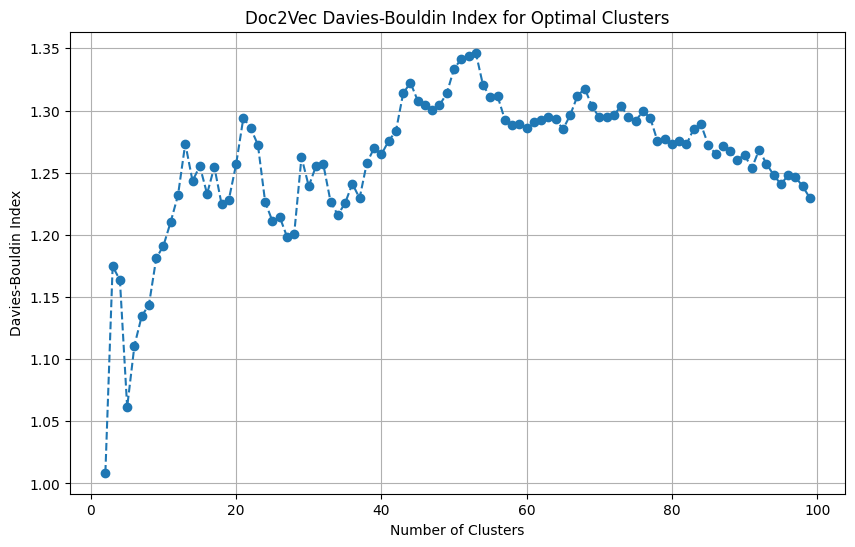

In [69]:
davies_bouldin_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(doc2vec_matrix)
    db_score = davies_bouldin_score(doc2vec_matrix, cluster_labels)
    davies_bouldin_scores.append(db_score)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, davies_bouldin_scores, marker='o', linestyle='--')
plt.title('Doc2Vec Davies-Bouldin Index for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.grid(True)
plt.show()

SBERT Elbow method

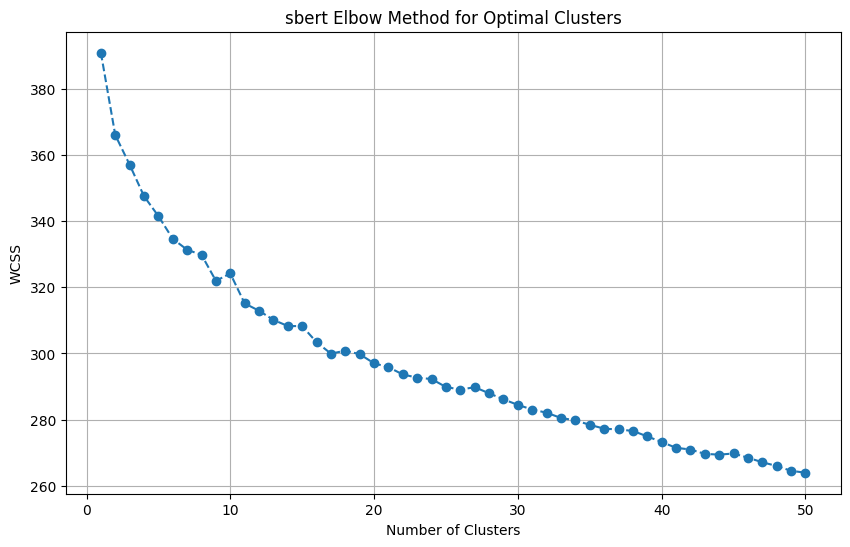

In [70]:
wcss = []
max_clusters = 50

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(sbert_matrix)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('sbert Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

SBERT silhouette_score

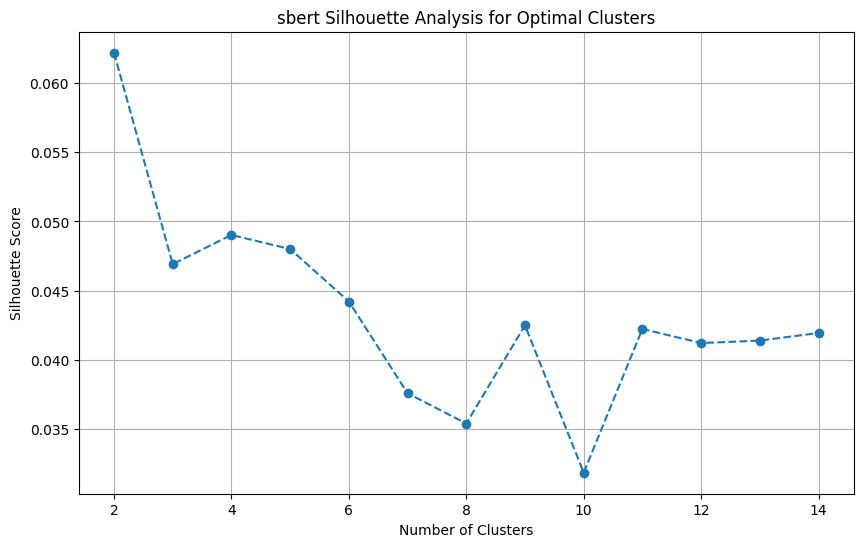

In [71]:
silhouette_scores = []
cluster_range = range(2, 15)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(sbert_matrix)
    silhouette_avg = silhouette_score(sbert_matrix, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='--')
plt.title('sbert Silhouette Analysis for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

SBERT Davies_bouldin_score

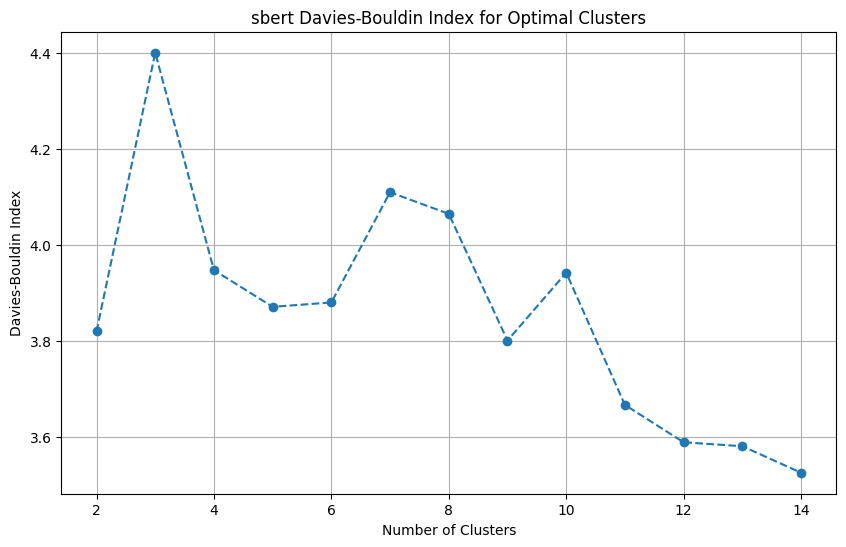

In [72]:
davies_bouldin_scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(sbert_matrix)
    db_score = davies_bouldin_score(sbert_matrix, cluster_labels)
    davies_bouldin_scores.append(db_score)

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, davies_bouldin_scores, marker='o', linestyle='--')
plt.title('sbert Davies-Bouldin Index for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.grid(True)
plt.show()

Result : Find out that Doc2Vec embedding is the best method for k-means clustering for this dataset. And n=7 for the clustering size is reasonable based on silhouette score, and Davies Bouldin score, and with the elbow method